# Forecasting Product Sales 
Forecasting sales figures is an important part of any business. It allows businesses to optimize processes such as resource allocation, hiring of staff and inventory management to name a few. Having reliable sales forecast enables leaders to make data driven decisions which will impact the longevity of the business.

Our task here is to forecast shampoo sales. We are given 3 years worth of monthly sales (in units sold) of this particular product. We will be implementing an **ARIMA Time Series Model** which is a one of the most popular model in the field of time series analysis. Before we commence with its implementation, it's important to note the limits of the model: We get the best results when making **short term forecasts**, updating the model with new data points as they become available. The further into the future we look, the lower the reliability of the forecasts.

We will use the Box-Jenkins method- which is a considered to be the framework of best practices when it comes to the production of time series models. The Box-Jenkins method is illustrated in the flow chart below:  

![](https://github.com/Qalif-R/ARIMA_Time_Series_Analysis/blob/main/box.png?raw=true)

In [1]:
#load in data set
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

url = 'https://raw.githubusercontent.com/Qalif-R/ARIMA_Time_Series_Analysis/main/shampoo_sales.txt'

warnings.filterwarnings('ignore')

dateparse = lambda x: datetime.strptime(x, '%Y-%m')

plt.rc("figure",figsize=(12,8))
sham_sales = pd.read_csv(url, delimiter=',', index_col='Month', parse_dates=True, date_parser=dateparse)

## Identification
We'll implement a train test split on the data- The fist 30 data points will be used to train the model, and the last 6 data points will be used to evaluate the performance of the model.

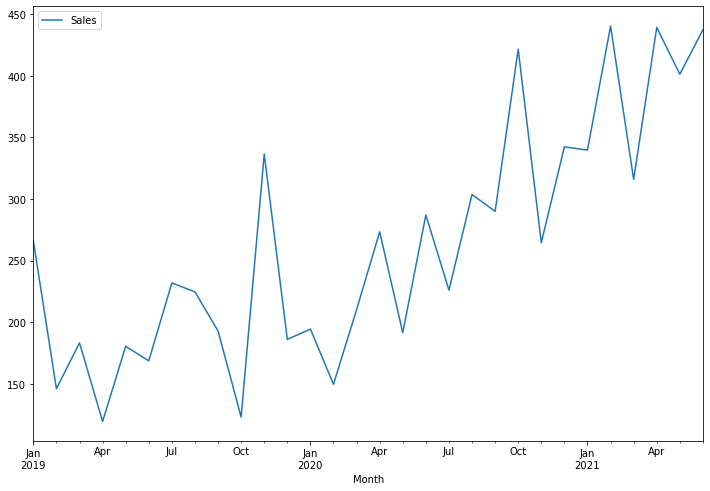

In [2]:
#Split into train and test set
train = sham_sales[:'2021-06']
test = sham_sales['2021-07':]

#Plot training data
train.plot()
plt.show()

Many traditional time series models (including ARIMA) rely on a time series property known as stationarity. A stationarity time series meet the following conditions:
 - No trend (not trending upwards or downwards)
 - Variance is constant (Distance between peeks and troughs remain roughly the same throughout)
 - Constant autocorrelation (The correlation between $Y_t$ and $Y_{t-h}$ is independent of $t$)
 
From the plot see that there is an upward trend downward over the past 3 years, so we can rule out stationarity. Since our time series is non-stationary, we must transform it into a stationary time series before we can fit into an ARIMA model. A common method to do this is differencing. To obtained a differenced time series, we subtract every data point with the previous data point.   

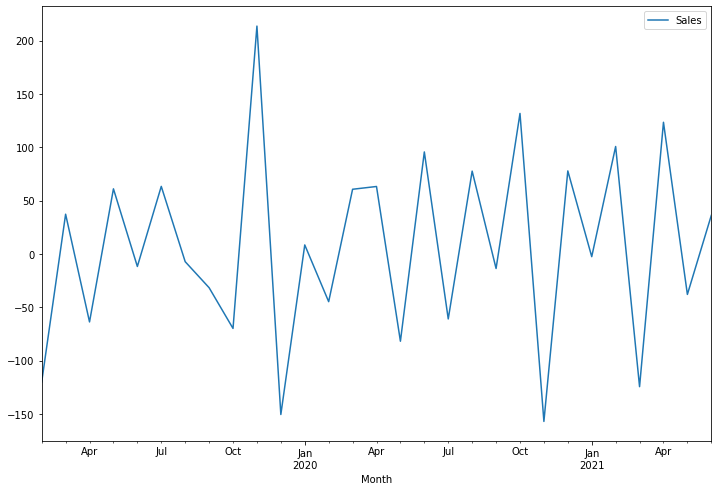

In [3]:
#Get 1st difference series
train_diff = train.diff().dropna()

#Plot time series of 1st differences
train_diff.plot()
plt.show()

The differenced series is now visually akin to a stationary time series. However, just inspecting its plot is not enough to confirm stationarity. To test if this time series is stationary, we can conduct the **augmented Dickey-Fuller** test, which is a hypothesis test with the following hypotheses:

$H_{0}$: the time series is non-stationary\
$H_{1}$: the time series is stationary

In [4]:
from statsmodels.tsa.stattools import adfuller
#Run ADF test
result = adfuller(train_diff['Sales'])

#Extract p-value of ADF test
p_value = result[1]

#Print p-value
print('The p-value for the test is {}'.format(p_value))

The p-value for the test is 1.7390606693039065e-08


Since the p_value is small (<0.05) we can reject the null hypothesis, so our differenced series is passes the augmented Dickey-Fuller test. We can now proceed to determine the other
hyperparameters of the ARIMA model. The ARIMA model takes three hyperparameters: $p,d,q$. 

$p$ represents the number of lagged terms included in the forecasted value. For example if $p=2$ then the time series is a function of previous 2 values of the time series.
$q$ represents the number of lagged errors included in the forecasted value. For example if $q=2$ then the time series is a function of the previous 2 errors term, with the error terms being defined as the difference in forecasted and actual values.
$d$ represents the number of times the series must be differenced for time series to become stationary.

We already determined that $d=1$. Now we will examine the autocorrelation function (ACF) and partial autocorrelation function (PACF) to get and idea of the optimal values for $p$ and $q$. Observing these plot will give us an idea on what the optimal values of the hyperparameters might be. 

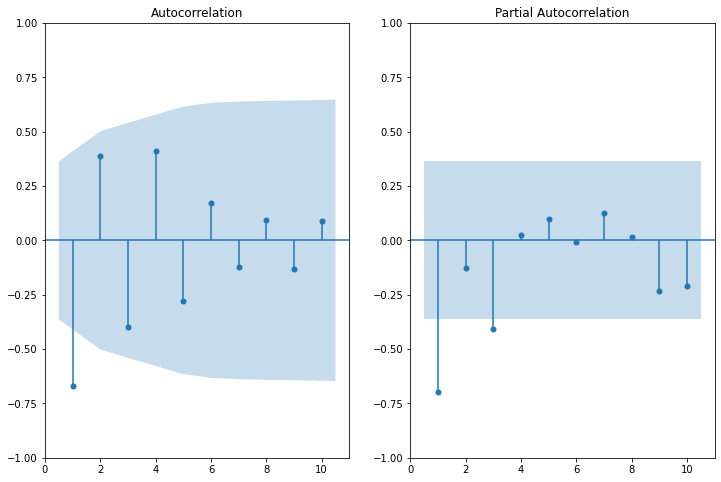

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1,2)
 
# Plot the ACF
plot_acf(train_diff, lags=10, zero=False, ax=ax1)

# Plot the PACF
plot_pacf(train_diff, lags=10, zero=False, ax=ax2)

plt.show()

## Estimation
The acf plot and pacf plot suggests that $p=3$ and $q=0$, as the ACF tails off and the PACF cuts off at lag $3$. To solidify our case for this set of hyper-parameters, we will conduct a grid search of parameters for all values of $p$ and $q$ $<= 3$ (as, from the plots, only lags up to lag 3 appear to be significant). We can then choose the model which gives us the lowest **Akaike Information Criterion (AIC)**. The AIC is a measrure which tells us how good of a fit a model is to the data- the lower the score, the better the fit.

In [6]:
import numpy as np
import pmdarima as pm

# Create auto_arima model using aic as metric
results_aic = pm.auto_arima(train,
                      d=1,trend='t',
                      max_p=3, max_q=3,
                      trace=True,
                      error_action='ignore',
                      information_criterion='aic',
                      suppress_warnings=True,
                      stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=346.169, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=328.803, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=329.641, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=322.677, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,1,0)(0,0,0)[1] intercept
Total fit time: 1.147 

the model with the lowest AIC score is $p=3, q=0$ suggesting that the best fit for 1st differenced time series is an autoregressive time series of order 3 or **AR(3)** for short.

## Model Diagnostics
We need to further assess the suitability of this model. To do this, we'll examine the **residuals** of the model. The residuals are the differences bewteen the values produced by the model values and the actual observed values. Ideally, the residuals should be a **white-noise process**, which means that the residuals should be a normally distributed and that there are no correlations in the residuals. Having the residuals conform to a white noise process means that that the differences between the values produced by the model and the actual observed values are random and do not follow a predictable pattern. To see if this is the case, we examine the diagnostic plots:

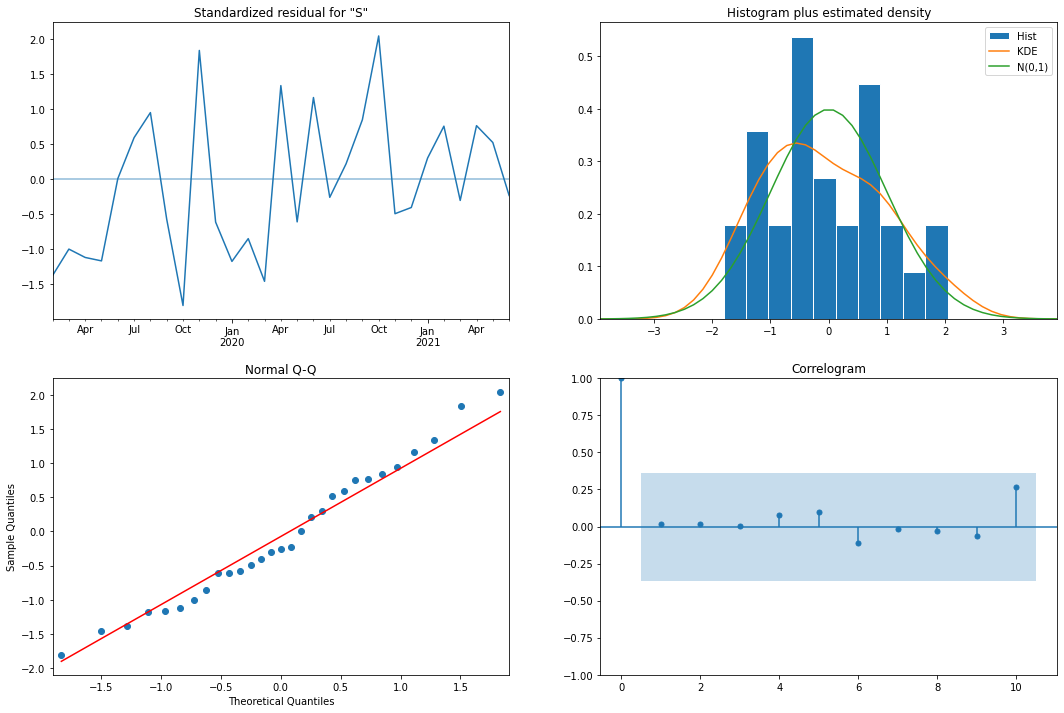

In [9]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

model = ARIMA(train, order=(3,1,0),trend='t')
results = model.fit()

#Create diagnostics plots
results.plot_diagnostics(figsize=(18,12))
plt.show()

The plot of the standardized residuals are consistent with a white noise process. The histogram and QQ plot suggest that the residuals approximately follow a normal distribution, while the correlogram indicates that the correlations of the residuals are not significant. Let's now see how this model predicts the unseen test data.

Now we need to evaluate how well the model predicts unseen data. We'll compare the forecasts produced to the test data. We'll also examine how it compares to ordinary least squares (OLS), which will act as our base model predictor. We plot the forecast from our ARIMA model, the base model and the observed data. We'll also compute the mean absolute error (MAE). 

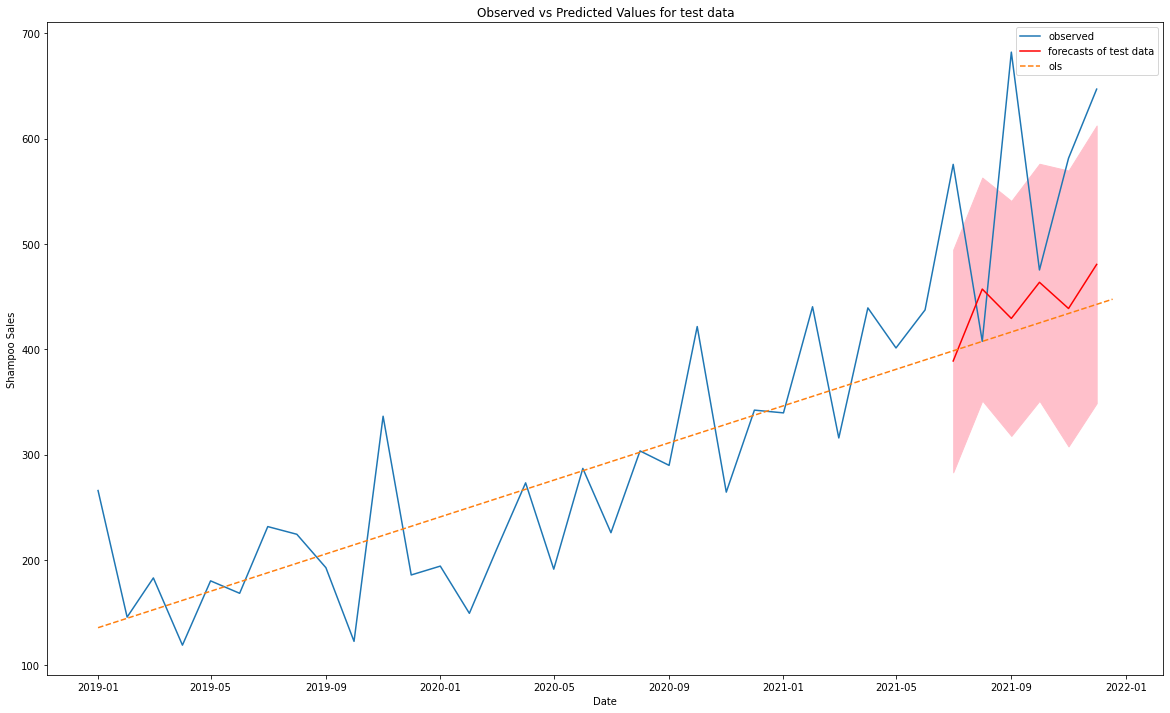

In [10]:
import matplotlib.dates as mdates

#Generate fitted values
forecast_values = results.get_forecast(steps=6)

# Extract prediction mean
forecast_means = forecast_values.predicted_mean

#Extract confidence interval
confidence_intervals = forecast_values.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Sales']
upper_limits = confidence_intervals.loc[:,'upper Sales']


#Plot training data
fig, ax = plt.subplots(figsize=(20,12))
plt.plot(sham_sales.index, sham_sales['Sales'], label='observed')
plt.fill_between(forecast_means.index, lower_limits, upper_limits, color='pink')

#Plot fitted value means
plt.plot(forecast_means.index, forecast_means, color='r', label='forecasts of test data')

#Plot OLS line for reference
x = mdates.date2num(train.index)
y = train['Sales']
z = np.polyfit(x,y,1)
p = np.poly1d(z)
#then the plot

x_values = [x[0], max(x)+200]
y_values = [p(x[0]), p(max(x)+200)]
plt.plot(x_values, y_values,linestyle="--",label='ols')


# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Shampoo Sales')
plt.title('Observed vs Predicted Values for test data')
plt.legend()
plt.show()

In [11]:
#Compute MAE for both models
mae_arima = np.mean(sum(abs(test.Sales - forecast_means))) 

#Get mse of ols model
test_date_int = mdates.date2num(test.index)
ols_pred = pd.Series([p(x) for x in test_date_int])
ols_pred.index = test.index

mae_ols = np.mean(sum(abs(test.Sales - ols_pred)))

print('The MAE for our ARIMA model is {}'.format(mae_arima))
print('The MAE for our base model is {}'.format(mae_ols))

The MAE for our ARIMA model is 809.3910042798864
The MAE for our base model is 844.2949083654836


## Improving model performance by using seasonality

The plot and MAEs suggest that our ARIMA model performs better than OLS, however we can observe that many of the actual observed test data lies outside of the confidence interval forecast produced.

We shall explore if implementing **seasonality** to our model can improve its performance. Notice from the plot above that an increase in sales usually very frequently followed by a decrease in sales. This suggests that perhaps the period of seasonality experienced by the data is an even number. We will searching and fitting some optimal **seasonal arima models (SARIMA)**, for seasonal periods 2,4,6,8. We'll then choose the one which produces the smallest MAE on the test data. 

In [12]:
#Define list of candidates for seasonal period
m_list = [2,4,6,8]

for m in m_list:
    # Create auto_arima model
    results = pm.auto_arima(train,
                            seasonal=True,m=m,trend='t',
                            d=1,D=0,
                            max_p=3, max_q=3,
                            max_P=3, max_Q=3,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=322.562, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=346.169, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=320.982, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=346.169, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[2] intercept   : AIC=328.803, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[2] intercept   : AIC=322.418, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[2] intercept   : AIC=322.374, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[2] intercept   : AIC=321.775, Time=0.05 sec
 ARIMA(1,1,0)(2,0,1)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[2] intercept   : AIC=343.428, Time=0.03 sec
 ARIMA(1,1,1)(1,0,0)[2] intercept   : AIC=321.033, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[2]             : AIC=320.982, Time=0.04 sec

Best model:  ARIMA(1,1,0)(1,0,0)[2]          
Total fit ti

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Define function which creates and fits on train data, predicts on test data and computes mae
def get_mae(p):
    model = SARIMAX(train, order=(p[0],p[1],p[2]), seasonal_order=(p[3],p[4],p[5],p[6]), trend='t')
    results = model.fit()
    #Generate fitted values
    forecast_values = results.get_forecast(steps=6)
    #Extract prediction mean
    forecast_means = forecast_values.predicted_mean
    #Compute mae
    mae = np.mean(sum(abs(test.Sales - forecast_means)))
    return mae

#Define parameters for each optimal sarima model    
params_dict = {2:[1,1,0,1,0,0,2],
               4:[2,1,0,3,0,0,4],
               6:[1,1,0,0,0,0,6],
               8:[1,1,0,0,0,0,8]}

#Calculate MAE for all optimal sarima models using function defined earlier
mae_dict = {}
for m in params_dict.keys():
    mae_dict[m] = get_mae(params_dict[m])

In [14]:
#Compare MAE of models with different seasonal periods
mae_dict

{2: 672.3718846895667,
 4: 539.9592577297399,
 6: 589.4655992342555,
 8: 589.4655992342555}

So we can see that using a **seasonal period of 4** yields the best performance in terms of MAE. Moreover, we see that all seasonal models yield a much lower MAE as compared to our standard arima model and the OLS model.
Now lets see visually how the SARIMA model's predictions compare to the OLS model. The diagnostic plots below suggest that the the residuals resemble white noise, smilar to our standard arima model earlier.

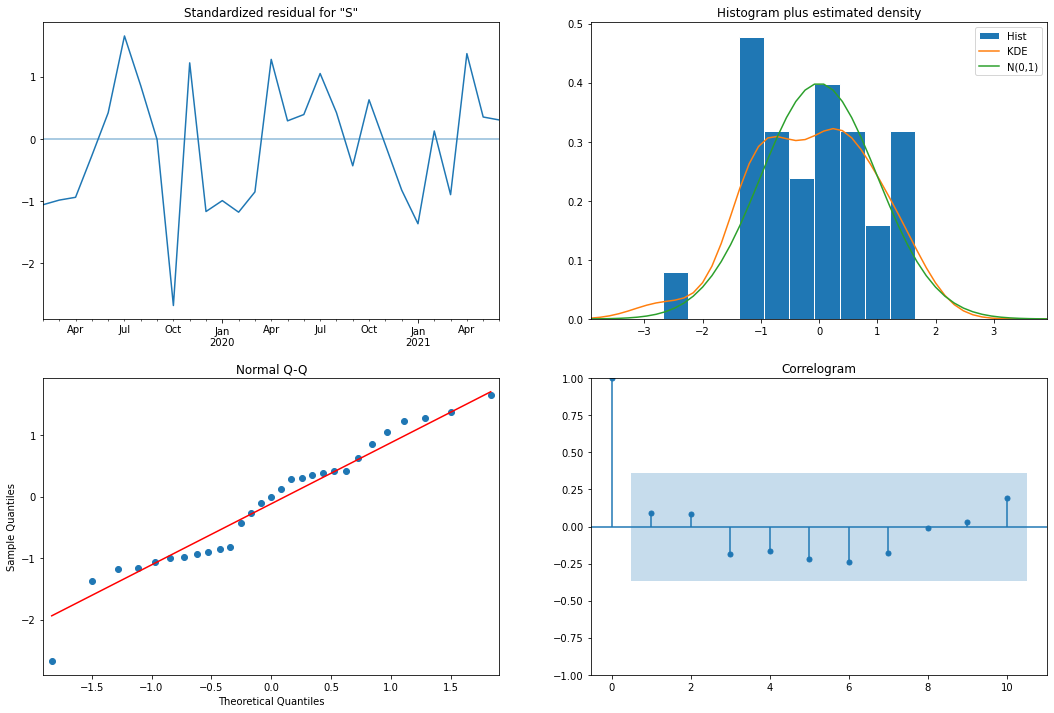

In [15]:
model = SARIMAX(train, order=(2,1,0), seasonal_order=(3,0,0,4), trend='t')
results = model.fit()

#Create diagnostics plots
results.plot_diagnostics(figsize=(18,12))
plt.show()

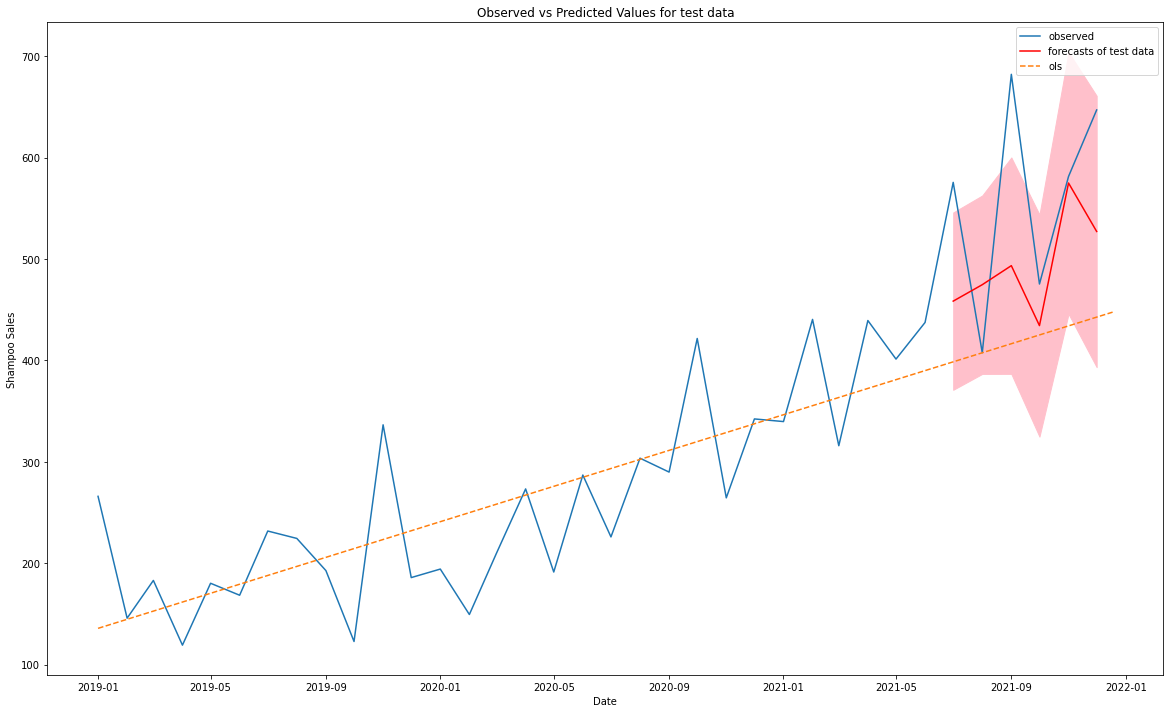

In [16]:
#Generate fitted values
forecast_values = results.get_forecast(steps=6)

# Extract prediction mean
forecast_means = forecast_values.predicted_mean

#Extract confidence interval
confidence_intervals = forecast_values.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Sales']
upper_limits = confidence_intervals.loc[:,'upper Sales']


#Plot training data and test data
fig, ax = plt.subplots(figsize=(20,12))
plt.plot(sham_sales.index, sham_sales['Sales'], label='observed')


#Plot fitted value means
plt.plot(forecast_means.index, forecast_means, color='r', label='forecasts of test data')
plt.fill_between(forecast_means.index, lower_limits, upper_limits, color='pink')

#Plot OLS line for reference
x = mdates.date2num(train.index)
y = train['Sales']
z = np.polyfit(x,y,1)
p = np.poly1d(z)
#then the plot

x_values = [x[0], max(x)+200]
y_values = [p(x[0]), p(max(x)+200)]
plt.plot(x_values, y_values,linestyle="--",label='ols')


# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Shampoo Sales')
plt.title('Observed vs Predicted Values for test data')
plt.legend()
plt.show()

Now most of the test data lies within the confidence interval produced by the SARIMA model. Although there are still some anomilies which lie outside this confidence interval, this model still performs much better compared to the standard arima and ols models. 

## Production
We have trained a few time series models and chosen the one which performs the best on the test data. We're now ready to make forecasts on future sales figures. We'll make forecast fore the next 6 months after the final data point available.

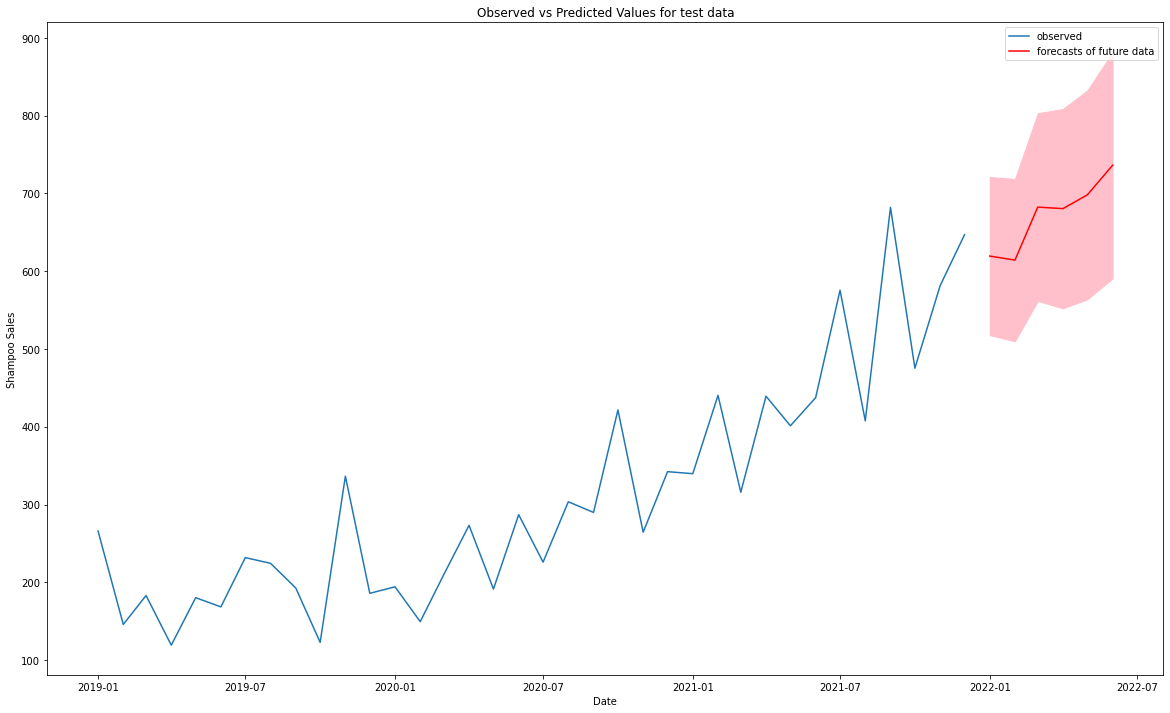

In [17]:
#Create and fit model
model_final = SARIMAX(sham_sales, order=(2,1,0), seasonal_order=(3,0,0,4), trend='t')
results = model_final.fit()

#Generate fitted values
forecast_values = results.get_forecast(steps=6)

# Extract prediction mean
forecast_means = forecast_values.predicted_mean

#Extract confidence interval
confidence_intervals = forecast_values.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Sales']
upper_limits = confidence_intervals.loc[:,'upper Sales']


#Plot historical data
fig, ax = plt.subplots(figsize=(20,12))
plt.plot(sham_sales.index, sham_sales['Sales'], label='observed')


#Plot fitted value means and confidence intervals
plt.plot(forecast_means.index, forecast_means, color='r', label='forecasts of future data')
plt.fill_between(forecast_means.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Shampoo Sales')
plt.title('Observed vs Predicted Values for test data')
plt.legend()
plt.show()

The forecasted means of sales values are:

In [18]:
pd.DataFrame(forecast_means)

,predicted_mean
2022-01-01,619.443253
2022-02-01,614.218367
2022-03-01,682.356023
2022-04-01,680.402309
2022-05-01,698.149052
2022-06-01,736.143673


while the values of the confidence intervals are:

In [19]:
confidence_intervals

,lower Sales,upper Sales
2022-01-01,517.777242,721.109264
2022-02-01,509.896641,718.540092
2022-03-01,561.724372,802.987674
2022-04-01,552.257995,808.546624
2022-05-01,563.886243,832.411861
2022-06-01,590.718260,881.569087


Now we'll just need to wait until we are able to get the actual future sales figures so that we can assess the forecasts made by our SARIMA model!